Generate some validation videos random, download them from the server and then use them to visualize the results.

In [1]:
import random
import os
import numpy as np
from work.dataset.activitynet import ActivityNetDataset

dataset = ActivityNetDataset(
    videos_path='../dataset/videos.json',
    labels_path='../dataset/labels.txt'
)
videos = dataset.get_subset_videos('validation')
videos = random.sample(videos, 8)

examples = []
for v in videos:
    file_dir = os.path.join('../downloads/features/', v.features_file_name)
    if not os.path.isfile(file_dir):
        os.system('scp imatge:~/work/datasets/ActivityNet/v1.3/features/{} ../downloads/features/'.format(v.features_file_name))
    features = np.load(file_dir)
    examples.append((v, features))

Load the trained model with its weigths

In [2]:
from keras.layers import Input, BatchNormalization, LSTM, TimeDistributed, Dense, merge
from keras.models import Model

input_features = Input(batch_shape=(1, 1, 4096,), name='features')
input_normalized = BatchNormalization()(input_features)
previous_output = Input(batch_shape=(1, 1, 202,), name='prev_output')
merging = merge([input_normalized, previous_output], mode='concat', concat_axis=-1)
lstm1 = LSTM(512, return_sequences=True, stateful=True, name='lstm1')(merging)
lstm2 = LSTM(512, return_sequences=True, stateful=True, name='lstm2')(lstm1)
output = TimeDistributed(Dense(201, activation='softmax'), name='fc')(lstm2)
model = Model(input=[input_features, previous_output], output=output)

model.load_weights('../work/scripts/training/lstm_activity_classification_feedback/model_snapshot/lstm_activity_classification_feedback_02_e100.hdf5')
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
features (InputLayer)              (1, 1, 4096)        0                                            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormaliz(1, 1, 4096)        8192        features[0][0]                   
____________________________________________________________________________________________________
prev_output (InputLayer)           (1, 1, 202)         0                                            
____________________________________________________________________________________________________
merge_1 (Merge)                    (1, 1, 4298)        0           batchnormalization_1[0][0]       
                                                                   prev_output[0][0]       

Extract the predictions for each video and print the scoring

In [3]:
predictions = []
for v, features in examples:
    nb_instances = features.shape[0]
    X = features.reshape((nb_instances, 1, 4096))
    
    prediction = np.zeros((nb_instances, 201))
    X_prev_output = np.zeros((1, 202))
    X_prev_output[0,201] = 1
    model.reset_states()
    for i in range(nb_instances):
        X_features = X[i,:,:].reshape(1, 1, 4096)
        X_prev_output = X_prev_output.reshape(1, 1, 202)
        next_output = model.predict_on_batch(
            {'features': X_features,
            'prev_output': X_prev_output}
        )
        prediction[i,:] = next_output[0,:]
        X_prev_output = np.zeros((1, 202))
        X_prev_output[0,:201] = next_output[0,:]
    class_prediction = np.argmax(prediction, axis=1)
    predictions.append((v, prediction, class_prediction))

Print the global classification results

Video ID: ekJtPwfLM-M		Main Activity: Breakdancing
0.5448	Doing step aerobics
0.3749	Zumba
0.0226	Rope skipping


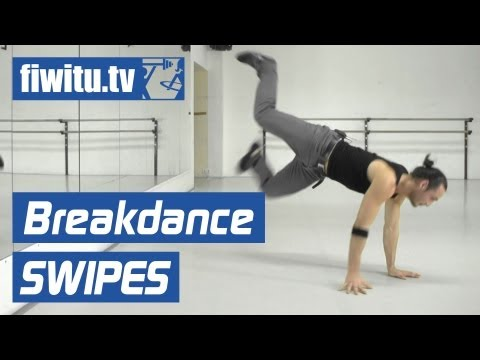



Video ID: Q9n6B1AVO4E		Main Activity: Putting in contact lenses
0.3115	Smoking a cigarette
0.2054	Washing face
0.1303	Putting in contact lenses


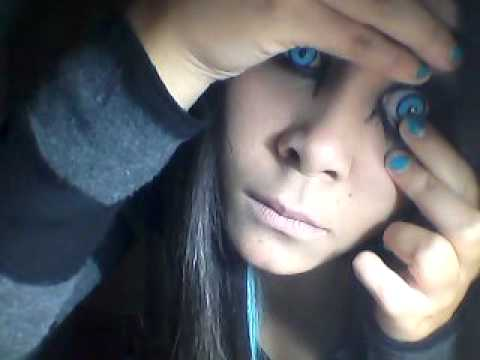



Video ID: p3PEMCN4h_g		Main Activity: Running a marathon
0.9999	Running a marathon
0.0000	Rollerblading
0.0000	Applying sunscreen


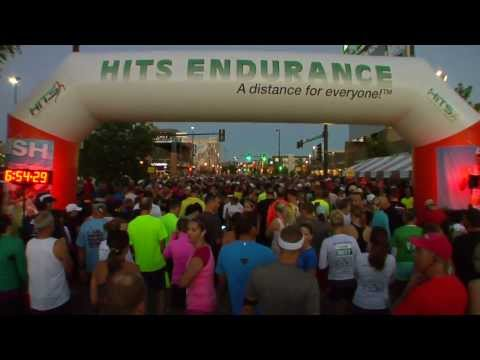



Video ID: HVKveVRZ-JY		Main Activity: Playing water polo
1.0000	Playing water polo
0.0000	Playing polo
0.0000	Waterskiing


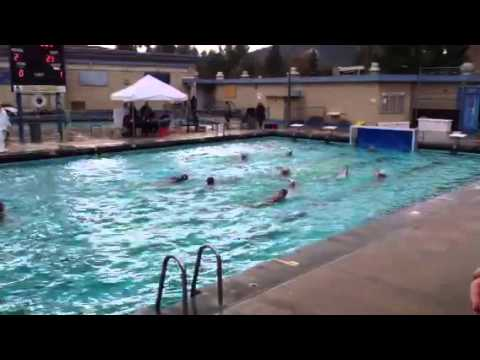



Video ID: YjxjsP6A5H8		Main Activity: Skateboarding
0.9549	Skateboarding
0.0089	Doing a powerbomb
0.0085	Carving jack-o-lanterns


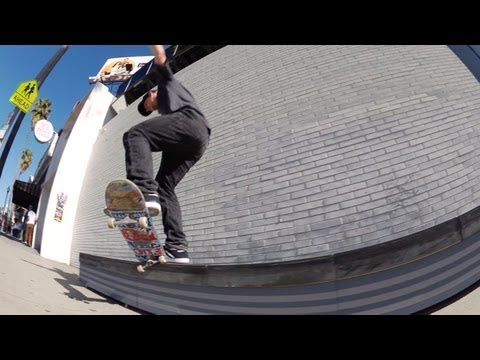



Video ID: YuuWL4EK7Q4		Main Activity: Polishing shoes
0.7518	BMX
0.2170	Playing polo
0.0203	Shuffleboard


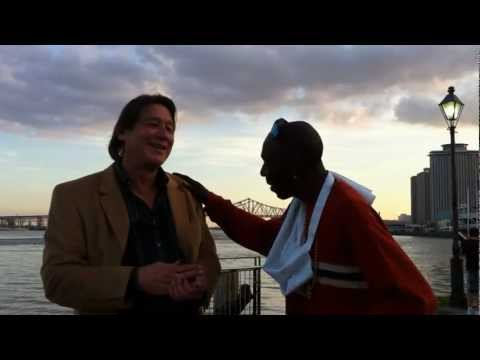



Video ID: O0KUnuhLwj0		Main Activity: Smoking a cigarette
0.3633	Getting a haircut
0.1204	Camel ride
0.0973	Beach soccer


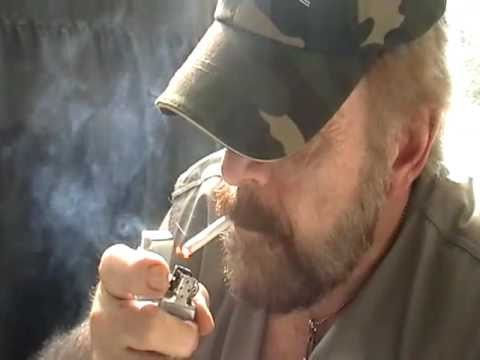



Video ID: YODfHuzK2As		Main Activity: Throwing darts
0.9929	Throwing darts
0.0020	Beer pong
0.0011	Brushing teeth


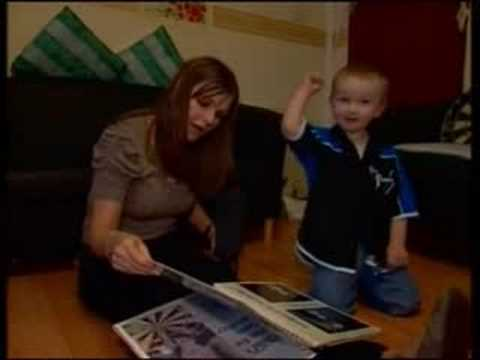

In [4]:
from IPython.display import YouTubeVideo, display

for v, prediction, class_prediction in predictions:
    print('Video ID: {}\t\tMain Activity: {}'.format(v.video_id, v.get_activity()))
    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))
    vid = YouTubeVideo(v.video_id)
    display(vid)
    print('\n')
    
    

Now show the temporal prediction for the activity happening at the video.

Video ID: ekJtPwfLM-M
Main Activity: Breakdancing


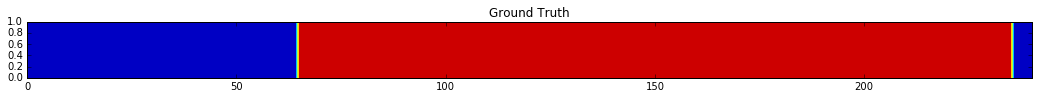

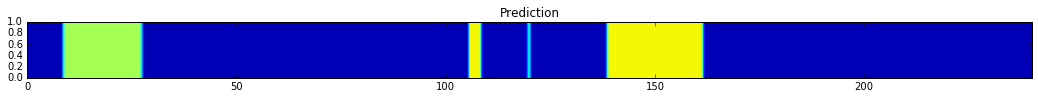



Video ID: Q9n6B1AVO4E
Main Activity: Putting in contact lenses


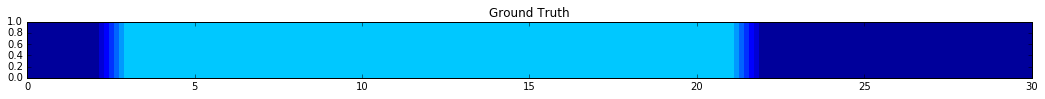

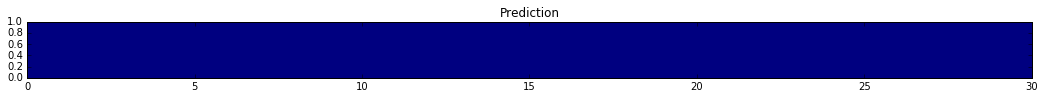



Video ID: p3PEMCN4h_g
Main Activity: Running a marathon


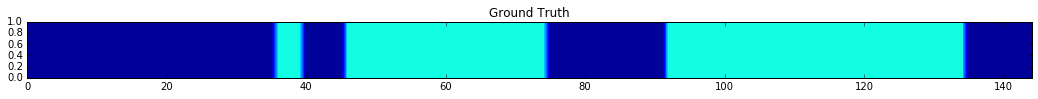

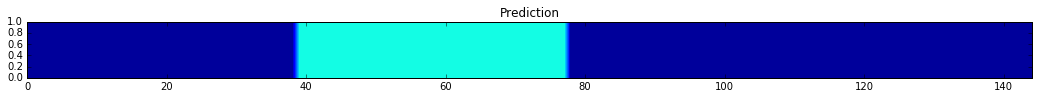



Video ID: HVKveVRZ-JY
Main Activity: Playing water polo


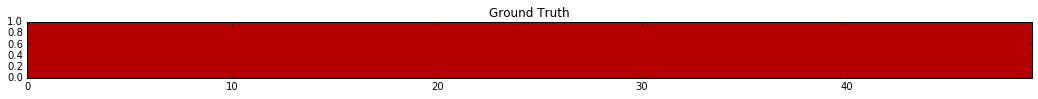

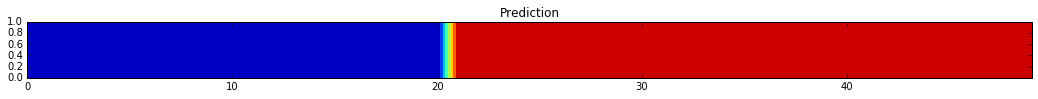



Video ID: YjxjsP6A5H8
Main Activity: Skateboarding


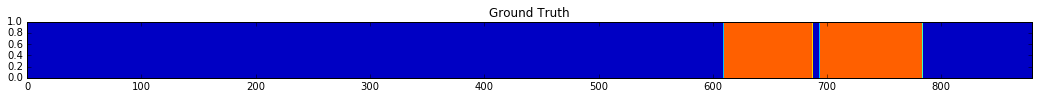

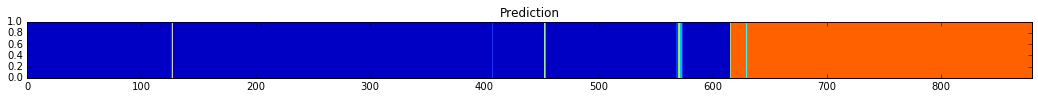



Video ID: YuuWL4EK7Q4
Main Activity: Polishing shoes


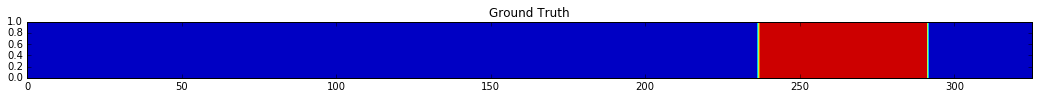

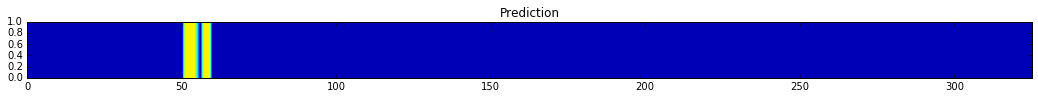



Video ID: O0KUnuhLwj0
Main Activity: Smoking a cigarette


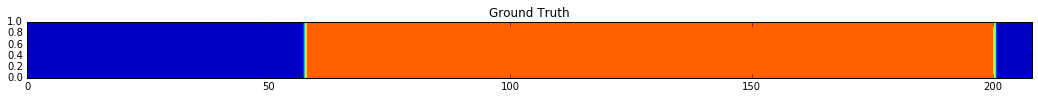

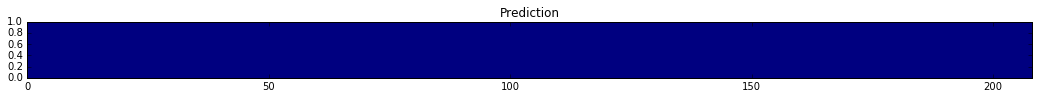



Video ID: YODfHuzK2As
Main Activity: Throwing darts


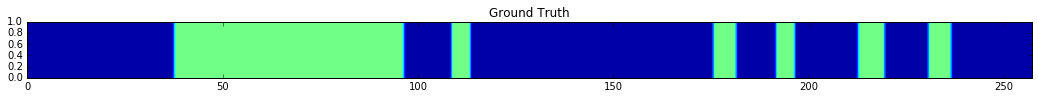

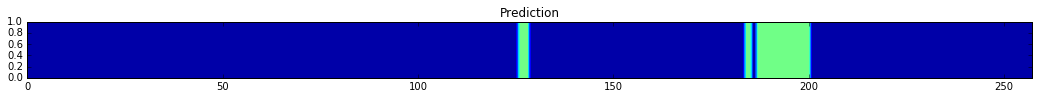

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
normalize = matplotlib.colors.Normalize(vmin=0, vmax=201)

for v, prediction, class_prediction in predictions:
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(class_prediction, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction')
    plt.show()

    print('\n')

Video ID: ekJtPwfLM-M
Main Activity: Breakdancing
0.5448	Doing step aerobics
0.3749	Zumba
0.0226	Rope skipping


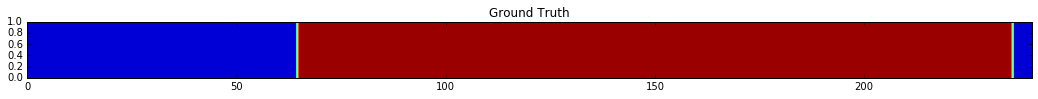

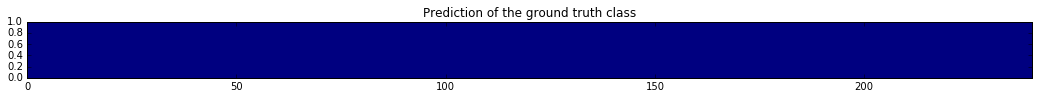

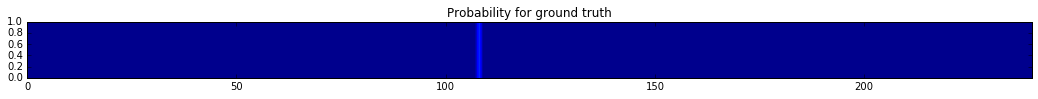



Video ID: Q9n6B1AVO4E
Main Activity: Putting in contact lenses
0.3115	Smoking a cigarette
0.2054	Washing face
0.1303	Putting in contact lenses


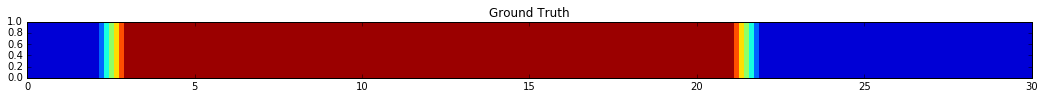

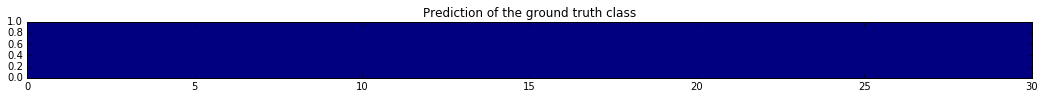

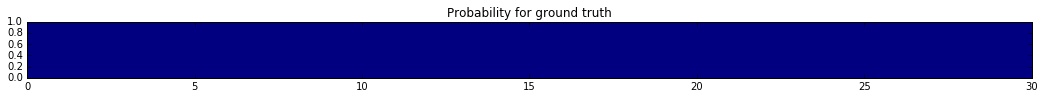



Video ID: p3PEMCN4h_g
Main Activity: Running a marathon
0.9999	Running a marathon
0.0000	Rollerblading
0.0000	Applying sunscreen


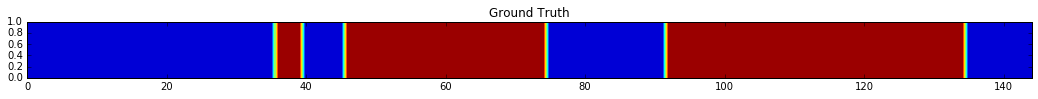

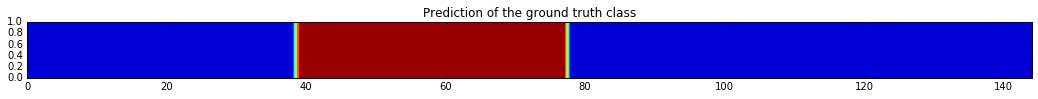

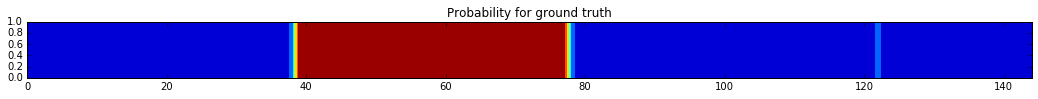



Video ID: HVKveVRZ-JY
Main Activity: Playing water polo
1.0000	Playing water polo
0.0000	Playing polo
0.0000	Waterskiing


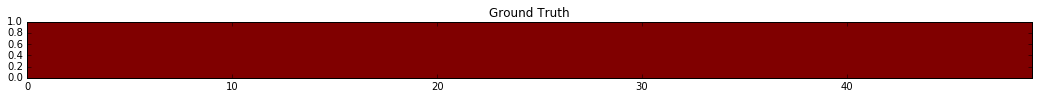

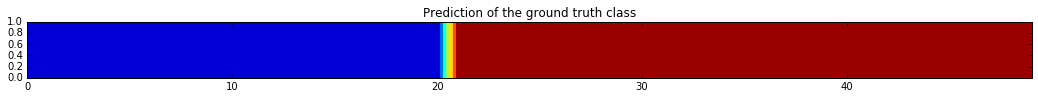

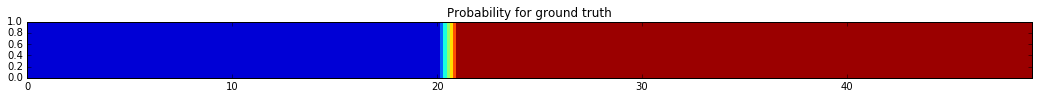



Video ID: YjxjsP6A5H8
Main Activity: Skateboarding
0.9549	Skateboarding
0.0089	Doing a powerbomb
0.0085	Carving jack-o-lanterns


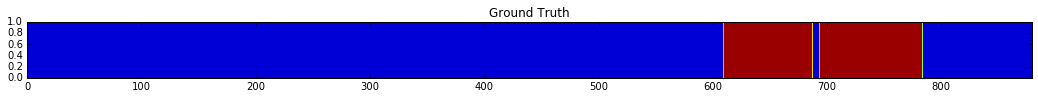

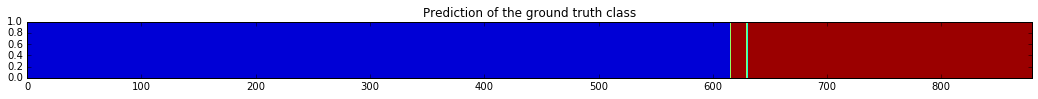

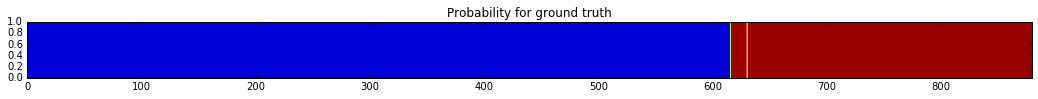



Video ID: YuuWL4EK7Q4
Main Activity: Polishing shoes
0.7518	BMX
0.2170	Playing polo
0.0203	Shuffleboard


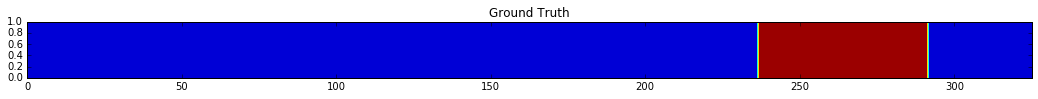

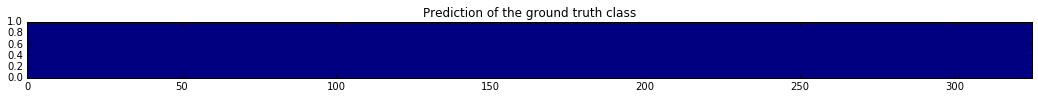

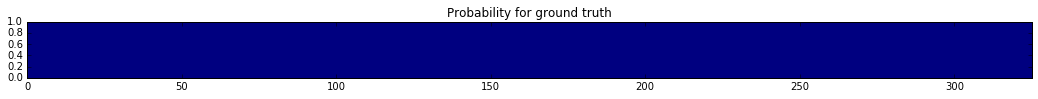



Video ID: O0KUnuhLwj0
Main Activity: Smoking a cigarette
0.3633	Getting a haircut
0.1204	Camel ride
0.0973	Beach soccer


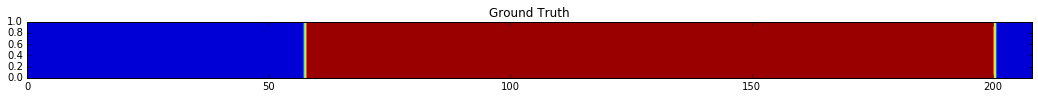

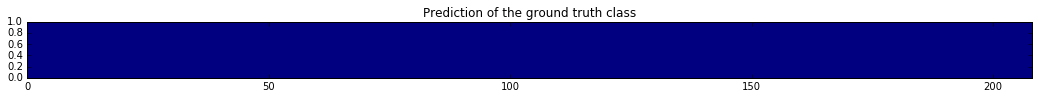

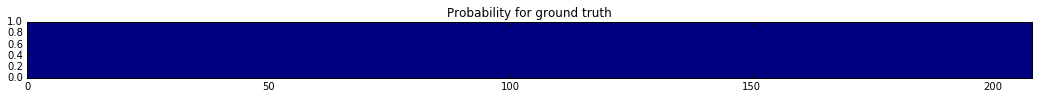



Video ID: YODfHuzK2As
Main Activity: Throwing darts
0.9929	Throwing darts
0.0020	Beer pong
0.0011	Brushing teeth


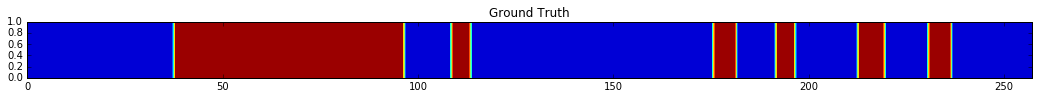

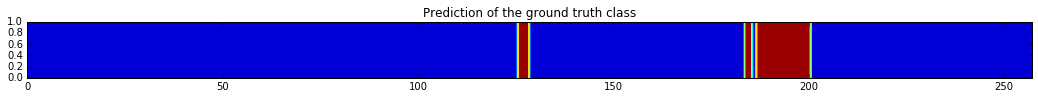

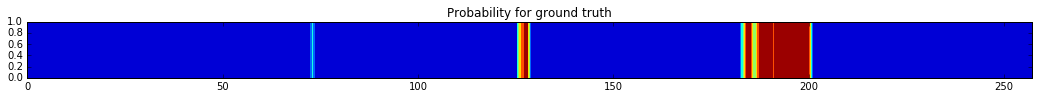

In [8]:
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)

for v, prediction, class_prediction in predictions:
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    output_index = dataset.get_output_index(v.label)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))

    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth/output_index, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    # print only the positions that predicted the global ground truth category
    temp = np.zeros((nb_instances))
    temp[class_prediction==output_index] = 1
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(temp, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction of the ground truth class')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(prediction[:,output_index], (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Probability for ground truth')
    plt.show()

    print('\n')